Algorithm terminated after 25 generations.
Best fitness using adaptive generation count: (394.7569775870352, 32.48621498154073)


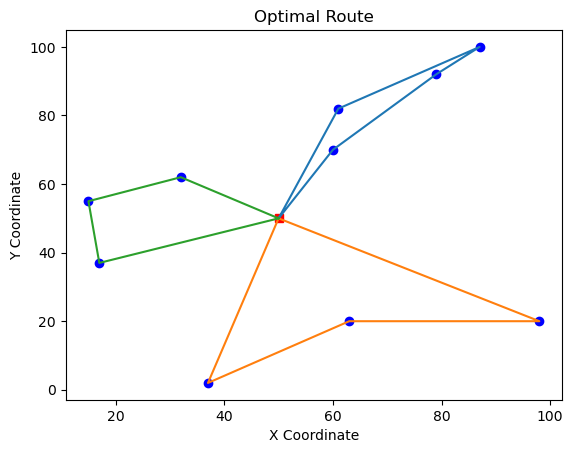

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

num_locations = 10  # Define how many locations (excluding the depot) the vehicles need to visit
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_locations)]  # Generate random (x, y) coordinates for each location
depot = (50, 50)  # Define the central depot location as a fixed point
num_vehicles = 3  # Define how many vehicles are available to visit the locations

# Genetic Algorithm Setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))  # Define fitness function to minimize. The two objectives are total distance and balance penalty.
creator.create("Individual", list, fitness=creator.FitnessMin)  # Define individual structure. Individuals are lists with a fitness attribute.

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_locations), num_locations)  # Function to generate a list of unique, randomly ordered location indices
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)  # Function to create an individual as a shuffled list of location indices
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Function to create a population of individuals

# Fitness Function
def evalVRP(individual):
    total_distance = 0
    distances = []  # Track distance traveled by each vehicle for balance calculation
    # Split the list of locations among vehicles, ensuring each starts and ends at the depot
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        # Calculate total distance traveled by this vehicle
        vehicle_distance = sum(np.linalg.norm(np.array(vehicle_route[k+1]) - np.array(vehicle_route[k])) for k in range(len(vehicle_route)-1))
        total_distance += vehicle_distance
        distances.append(vehicle_distance)
    balance_penalty = np.std(distances)  # Use standard deviation of distances as a penalty for imbalance among vehicles
    return total_distance, balance_penalty

toolbox.register("evaluate", evalVRP)  # Register the evaluation function
toolbox.register("mate", tools.cxPartialyMatched)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Plotting Function
def plot_routes(individual, title="Routes"):
    plt.figure()
    # Plot locations as blue dots and the depot as a red square
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    # Draw routes for each vehicle
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        plt.plot(*zip(*vehicle_route), '-')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

# Running the Genetic Algorithm
def main():
    random.seed(42)  # Seed for reproducibility
    pop = toolbox.population(n=300)  # Generate initial population
    hof = tools.HallOfFame(1)  # Hall of Fame to store the best individual
    
    # Setup statistics to track
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    max_generations = 300
    stagnation_limit = 20  # Stop if no significant improvement in 20 generations
    threshold = 0.001      # Minimum 1% improvement to reset stagnation
    stagnation_counter = 0
    previous_best = None


    # # Run the genetic algorithm for fixed number of generations
    # algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 300, stats=stats, halloffame=hof)
    # print(f"Best fitness using fixed generations: {hof[0].fitness.values}")
    # plot_routes(hof[0], "Optimal Route")

    gen = 0
    while gen < max_generations and stagnation_counter < stagnation_limit:
        # Run one generation
        pop, logbook = algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 1, stats=stats, halloffame=hof, verbose=False)
        current_best = hof[0].fitness.values[0]

        # Check for improvement
        if previous_best is not None:
            improvement = abs(previous_best - current_best) / previous_best
            if improvement < threshold:
                stagnation_counter += 1
            else:
                stagnation_counter = 0  # Reset if significant improvement
        previous_best = current_best

        # Increment generation counter
        gen += 1

    print(f"Algorithm terminated after {gen} generations.")
    print(f"Best fitness using adaptive generation count: {hof[0].fitness.values}")

    
    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
    main()
